# P-MALA

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_l_bfgs_b
import prox_tv as ptv
import cv2
import threading

# Set random seed
np.random.seed(42)

# Set number of threads to use for prox_tv
n_threads = max(1, threading.active_count() - 1)
print(f"Using {n_threads} threads for prox_tv")

Using 6 threads for prox_tv


## P-MALA Sampler

In [2]:
def p_mala_sampler(logpdf, prox, x0, delta, n_iter, burn_in=None, adaptive=False, gamma=0.1, acceptance_rate_batch=50, acceptance_rate_target=0.5):
    """
    Proximal MALA sampler.
    
    Parameters:
        logpdf: Function computing log π(x) (up to a constant).
        prox: Function computing the proximal operator prox_g(x, delta).
        x0: Initial state (scalar or array).
        delta: Step size parameter.
        n_iter: Number of iterations.
        
        burn_in (optional): Number of burn-in iterations.
        adaptive (optional): If True, adapt the step size during sampling.
        gamma (optional): Adaptation rate.
        acceptance_rate_batch (optional): Batch size for computing acceptance rate.
        acceptance_rate_target (optional): Target acceptance rate.
      
    Returns:
        samples: Array of samples with shape (n_iter, *x0.shape).
        acceptance_rates: Array of acceptance rates computed every batch.
        acceptance_rates_burn_in_threshold: Burn-in threshold for acceptance rates.
    """
    assert burn_in is None or burn_in < n_iter, "Burn-in must be smaller than n_iter."
    # Adaptive must be False if burn-in is not set
    assert not (adaptive and burn_in is None), "Adaptive must be False if burn-in is not set."

    x = np.atleast_1d(x0).astype(np.float64)
    prox_x = prox(x, delta / 2)
    samples = np.zeros((n_iter, *x.shape))
    acceptance_rates = np.zeros(n_iter // acceptance_rate_batch)
    
    accepts = 0
    samples[0] = x
    
    for i in range(1, n_iter):
        # Propose candidate from a Gaussian centered at prox_x
        y = prox_x + np.sqrt(delta) * np.random.randn(*x.shape)
        prox_y = prox(y, delta / 2)
        
        log_q_y_given_x = -0.5 * np.sum((y - prox_x) ** 2) / delta
        log_q_x_given_y = -0.5 * np.sum((x - prox_y) ** 2) / delta
        
        log_ratio = logpdf(y) - logpdf(x) + log_q_x_given_y - log_q_y_given_x
        
        if np.log(np.random.rand()) < log_ratio:
            x = y
            prox_x = prox_y
            accepts += 1
        
        samples[i] = x
        
        # Adapt delta every 'acceptance_rate_batch' iterations
        if i % acceptance_rate_batch == 0:
            current_acceptance_rate = accepts / acceptance_rate_batch
            acceptance_rates[i // acceptance_rate_batch] = current_acceptance_rate
            accepts = 0
            if adaptive:
                if burn_in is not None and i < burn_in:
                    delta *= np.exp(gamma * (current_acceptance_rate - acceptance_rate_target))
    
    # Discard burn-in samples and add burn-in threshold for acceptance rates
    if burn_in is not None:
        samples = samples[burn_in:]
        acceptance_rates_burn_in_threshold = burn_in // acceptance_rate_batch
    else:
        acceptance_rates_burn_in_threshold = None
    return samples, acceptance_rates, acceptance_rates_burn_in_threshold

## One-dimensional sampling: Laplace distribution

### Densities and proximal operators

In [3]:
def soft_threshold(x, threshold):
    """
    Soft-thresholding operator for a scalar or array x.
    
    Parameters
        x: Scalar or array.
        threshold: Threshold value.

    Returns
        Scalar or array.
    """
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def prox_laplace(x, delta):
    """
    Proximity operator for g(u) = -|u| with parameter delta.

    Parameters:
        x: Scalar or array.
        delta: Proximity operator parameter.

    Returns:
        Scalar or array.
    """
    return soft_threshold(x, delta)

def logpdf_laplace(x):
    """
    Log-density for the Laplace distribution:
      g(x) = -|x|
    so that π(x) ∝ exp(-|x|).

    Parameters:
        x: Scalar or array.

    Returns:
        Scalar or array.
    """
    return -np.abs(x)

### Sample data

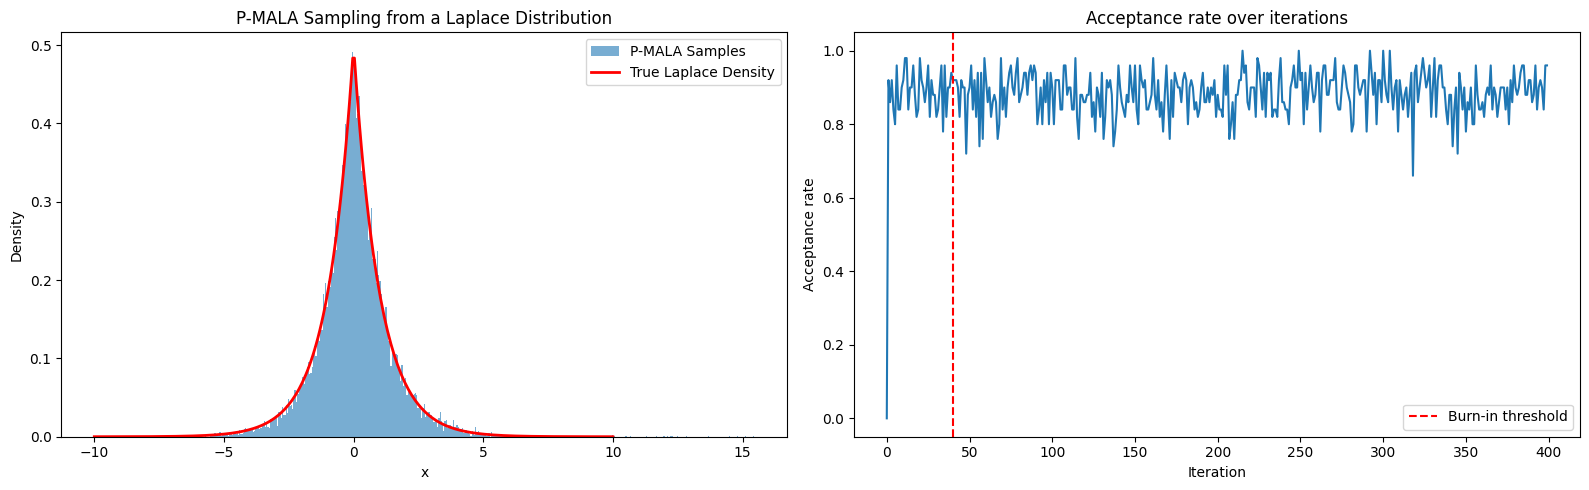

In [4]:
n_iter = 20000 # Number of iterations
burn_in = int(0.1 * n_iter) # Burn-in period
delta = 1 # Step size parameter; experiment with this value
x0 = 5.0 # Initial state
adaptive = False # Adapt the step size during burn-in

# Run the P-MALA sampler
samples, acceptance_rates, acceptance_rates_burn_in_threshold = p_mala_sampler(logpdf_laplace, prox_laplace, x0, delta, n_iter, burn_in=burn_in, adaptive=adaptive)

# Plot histogram and true density
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(samples, bins=500, density=True, alpha=0.6, label='P-MALA Samples')
xs = np.linspace(-10, 10, 300)
laplace_pdf = 0.5 * np.exp(-np.abs(xs))
plt.plot(xs, laplace_pdf, 'r-', lw=2, label='True Laplace Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('P-MALA Sampling from a Laplace Distribution')
plt.legend()

# Plot acceptance rates
plt.subplot(1, 2, 2)
plt.plot(acceptance_rates)
if acceptance_rates_burn_in_threshold is not None: # Plot burn-in threshold
    plt.axvline(acceptance_rates_burn_in_threshold, color='r', linestyle='--', label='Burn-in threshold')
plt.xlabel('Iteration')
plt.ylabel('Acceptance rate')
plt.title('Acceptance rate over iterations')
plt.legend()

plt.tight_layout()
plt.show()

## One dimensional denoising: Smooth TV prior

### Densities and proximal operators

In [5]:
def log_posterior_1D(x, y, alpha=10.0, sigma=0.2):
    """
    Compute the negative log-posterior for 1D data with a total variation prior.
    
    Parameters:
      x: Current estimate of the signal.
      y: Observed noisy data.
      alpha: Regularization parameter for the TV prior.
      sigma: Noise standard deviation.
    
    Returns:
      Negative log-posterior value.
    """
    likelihood = -np.sum((y - x)**2) / (2 * sigma**2)
    prior = -alpha * np.sum(np.abs(np.diff(x)))
    return -(likelihood + prior)

def prox_tv_1D(x, y, delta, alpha=10.0, sigma=0.2):
    """
    Proximal operator for the TV prior for 1D data.
    
    Parameters:
      x: Current signal estimate.
      y: Observed data.
      delta: Step size parameter.
      alpha: Regularization parameter for the TV prior.
      sigma: Noise standard deviation.
    
    Returns:
      The proximal mapping of x.
    """
    return ptv.tv1_1d(x + 0.5 * delta * (y - x) / sigma**2, 0.5 * alpha * delta)

### Estimate the confidence interval on generated data

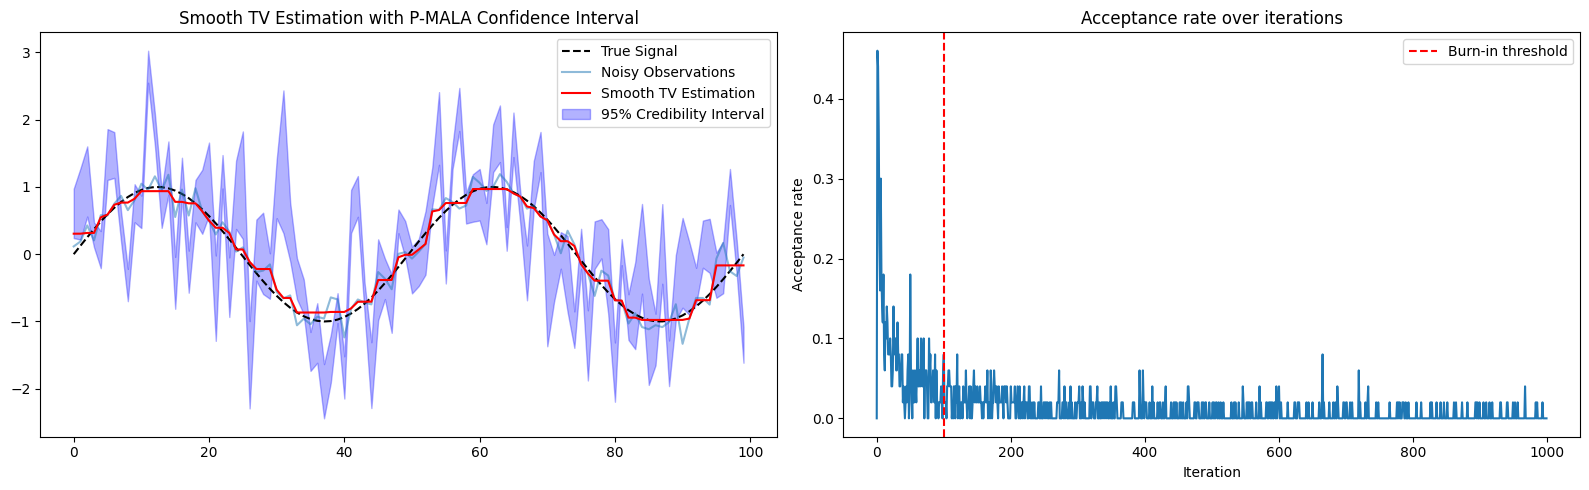

In [6]:
# Generate data
n = 100  # Number of points
sigma = 0.2  # Noise level
x_true = np.sin(np.linspace(0, 4 * np.pi, n))  # True signal
y = x_true + sigma * np.random.randn(n)  # Noisy observations

# MAP Estimation using Scipy Optimizer
x0 = y.copy()
res = minimize(log_posterior_1D, x0, args=(y,), method='L-BFGS-B')
x_map = res.x

# Run the P-MALA sampler
n_iter = 50_000 # Number of iterations
burn_in = int(0.1 * n_iter) # Burn-in period
delta = 0.001 # Step size parameter
sigma = 0.2 # Supposed noise level
adaptive = False # Adapt the step size during burn-in
samples, acceptance_rates, acceptance_rates_burn_in_threshold = p_mala_sampler(
    lambda x: log_posterior_1D(x, y, sigma=sigma),
    lambda x, delta: prox_tv_1D(x, y, delta, sigma=sigma),
    x_map, delta, n_iter, burn_in=burn_in, adaptive=adaptive
)

# Compute 95% Credibility Intervals (ignoring the burn-in period)
ci_lower = np.percentile(samples[500:], 2.5, axis=0)
ci_upper = np.percentile(samples[500:], 97.5, axis=0)

# Plot MAP and P-MALA results
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(x_true, label='True Signal', linestyle='dashed', color='black')
plt.plot(y, label='Noisy Observations', alpha=0.5)
plt.plot(x_map, label='Smooth TV Estimation', color='red')
plt.fill_between(range(n), ci_lower, ci_upper, color='blue', alpha=0.3, label='95% Credibility Interval')
plt.legend()
plt.title('Smooth TV Estimation with P-MALA Confidence Interval')

# Plot acceptance rates
plt.subplot(1, 2, 2)
plt.plot(acceptance_rates)
if acceptance_rates_burn_in_threshold is not None: # Plot burn-in threshold
    plt.axvline(acceptance_rates_burn_in_threshold, color='r', linestyle='--', label='Burn-in threshold')
plt.xlabel('Iteration')
plt.ylabel('Acceptance rate')
plt.title('Acceptance rate over iterations')
plt.legend()

plt.tight_layout()
plt.show()

### Adding the adaptative step size

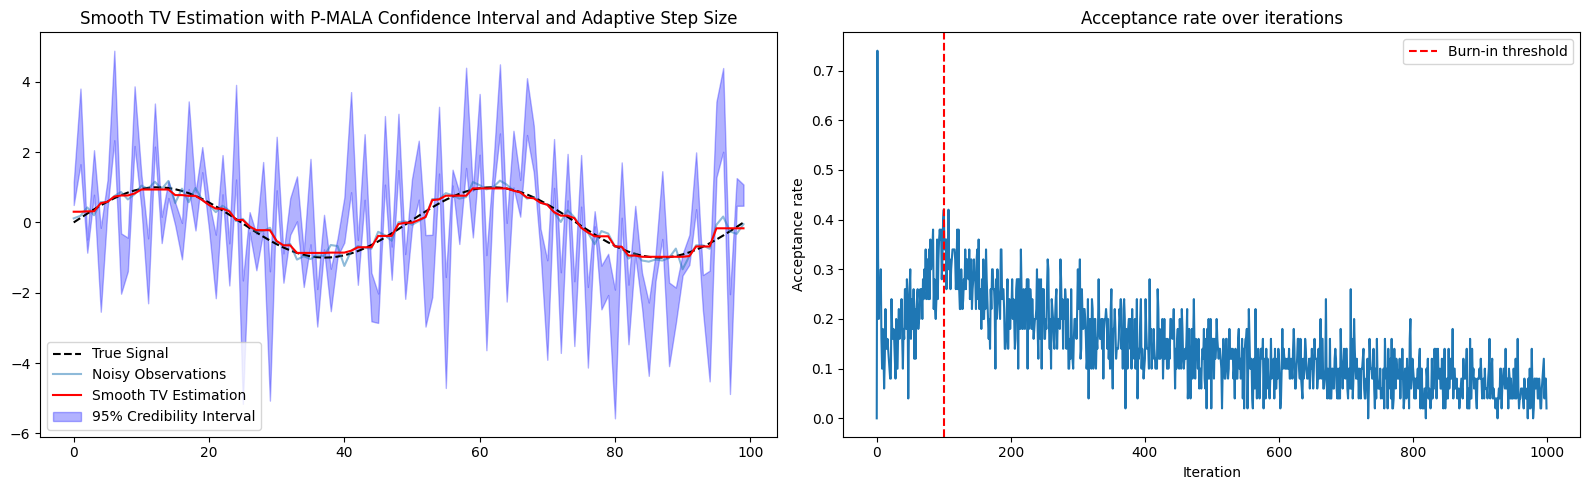

In [7]:
samples, acceptance_rates, acceptance_rates_burn_in_threshold = p_mala_sampler(
    lambda x: log_posterior_1D(x, y, sigma=sigma),
    lambda x, delta: prox_tv_1D(x, y, delta, sigma=sigma),
    x_map, delta, n_iter, burn_in=burn_in, adaptive=True
)

# Compute 95% Credibility Intervals (ignoring the burn-in period)
ci_lower = np.percentile(samples[500:], 2.5, axis=0)
ci_upper = np.percentile(samples[500:], 97.5, axis=0)

# Plot MAP and P-MALA results
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(x_true, label='True Signal', linestyle='dashed', color='black')
plt.plot(y, label='Noisy Observations', alpha=0.5)
plt.plot(x_map, label='Smooth TV Estimation', color='red')
plt.fill_between(range(n), ci_lower, ci_upper, color='blue', alpha=0.3, label='95% Credibility Interval')
plt.legend()
plt.title('Smooth TV Estimation with P-MALA Confidence Interval and Adaptive Step Size')

# Plot acceptance rates
plt.subplot(1, 2, 2)
plt.plot(acceptance_rates)
if acceptance_rates_burn_in_threshold is not None: # Plot burn-in threshold
    plt.axvline(acceptance_rates_burn_in_threshold, color='r', linestyle='--', label='Burn-in threshold')
plt.xlabel('Iteration')
plt.ylabel('Acceptance rate')
plt.title('Acceptance rate over iterations')
plt.legend()

plt.tight_layout()
plt.show()

## Image application: Smooth TV Prior

### Densities and proximal operators

In [8]:
def log_posterior_2D(x, y, alpha=10.0, sigma=0.2):
    """
    Compute the negative log-posterior for 1D data with a total variation prior.
    Can also be used for 1D data (scipy optimization).
    
    Parameters:
      x: Current estimate of the signal.
      y: Observed noisy data.
      alpha: Regularization parameter for the TV prior.
      sigma: Noise standard deviation.
    
    Returns:
      Negative log-posterior value.
    """
    if len(x.shape) == 1: # 1D case
        axis_0 = int(np.round(np.sqrt(x.shape[0])))
        x = x.reshape(axis_0,axis_0)
    likelihood = -np.sum((y - x)**2) / (2 * sigma**2)
    tv_h = np.abs(np.diff(x, axis=0))
    tv_v = np.abs(np.diff(x, axis=1))
    prior = -alpha * (np.sum(tv_h) + np.sum(tv_v))
    return -(likelihood + prior)

def prox_tv_2D(x, y, delta, alpha=10.0, sigma=0.2):
    """
    Proximal operator for the TV prior for 2D data.
    
    Parameters:
      x: Current signal estimate.
      y: Observed data.
      delta: Step size parameter.
      alpha: Regularization parameter for the TV prior.
      sigma: Noise standard deviation.
    
    Returns:
      The proximal mapping of x.
    """
    return ptv.tv1_2d(x + 0.5 * delta * (y - x) / sigma**2, 0.5 * alpha * delta, n_threads=6)

### Load the image

In [9]:
# Load image and normalize
image = cv2.imread('cameraman.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
image = cv2.resize(image, (64, 64))

# Add Gaussian noise
sigma = 0.1
y = image + sigma * np.random.randn(*image.shape)

### Estimate the confidence interval on generated data

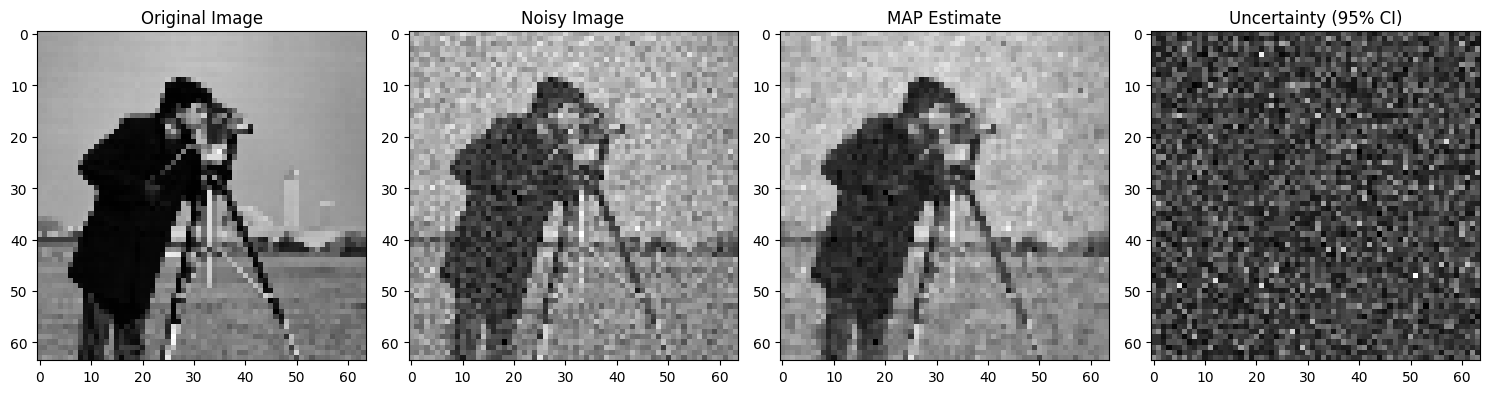

In [10]:
# MAP Estimation
x0 = y.copy()
x_map, _, _ = fmin_l_bfgs_b(log_posterior_2D, x0, args=(y,), approx_grad=True, maxiter=100)
axis_0 = int(np.round(np.sqrt(x_map.shape[0])))
x_map = x_map.reshape(axis_0,axis_0)

# Run the P-MALA sampler
n_iter = 50_000 # Number of iterations
burn_in = int(0.1 * n_iter) # Burn-in period
delta = 0.001 # Step size parameter
sigma = 0.2 # Supposed noise level
adaptive = False # Adapt the step size during burn-in
samples, acceptance_rates, acceptance_rates_burn_in_threshold = p_mala_sampler(
    lambda x: log_posterior_2D(x, y, sigma=sigma),
    lambda x, delta: prox_tv_2D(x, y, delta, sigma=sigma),
    x_map, delta, n_iter, burn_in=burn_in, adaptive=adaptive
)

# Compute 95% Credibility Intervals
ci_lower = np.percentile(samples, 2.5, axis=0)
ci_upper = np.percentile(samples, 97.5, axis=0)

# Display Results
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(y, cmap='gray')
axs[1].set_title('Noisy Image')
axs[2].imshow(x_map, cmap='gray')
axs[2].set_title('MAP Estimate')
axs[3].imshow(ci_upper - ci_lower, cmap='gray')
axs[3].set_title('Uncertainty (95% CI)')
plt.tight_layout()
plt.show()

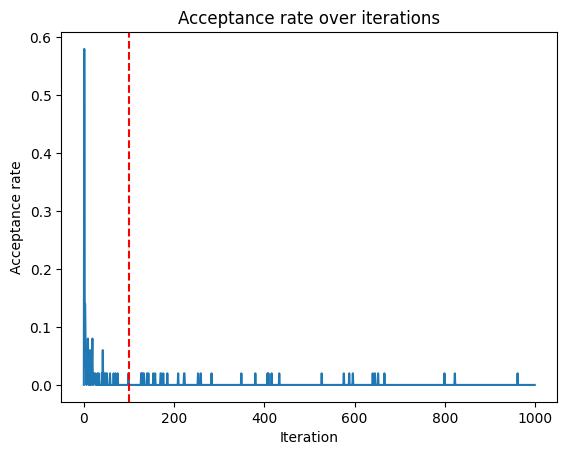

In [11]:
plt.plot(acceptance_rates)
if acceptance_rates_burn_in_threshold is not None: # Plot burn-in threshold
    plt.axvline(acceptance_rates_burn_in_threshold, color='r', linestyle='--', label='Burn-in threshold')
plt.xlabel('Iteration')
plt.ylabel('Acceptance rate')
plt.title('Acceptance rate over iterations')
plt.show()